# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. Comma Separated fFile
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#from google.colab import drive
#drive.mount("/content/gdrive")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import  MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#from gensim.models import Word2Vec
#from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
# con = sqlite3.connect('/content/gdrive/My Drive/Amazon Fine Food Reviews/database.sqlite') 
con = sqlite3.connect("database.sqlite")
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and above 3 to be positive
actualScore = filtered_data['Score']
status = actualScore.map(partition) 
filtered_data['Score'] = status
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
# Which Product ID has more helpful review clicks than not helpful clicks?
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Time, Score, Text, COUNT(*)
FROM Reviews
WHERE HelpfulnessNumerator>HelpfulnessDenominator
""", con)

In [5]:
print(display.shape)
display

(1, 9)


,UserId,ProductId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Score,Text,COUNT(*)
0,A2V0I904FH7ABY,B001EQ55RW,Ram,3,2,1212883200,4,It was almost a 'love at first bite' - the per...,2


In [6]:
# How many users have written multiple reviews?
display2 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display2.shape)
display2

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2
...,...,...,...,...,...,...,...
80663,AZZNK89PXD006,B001J3ZUQ6,Etude,1269648000,5,In this package you get three varieties of pop...,6
80664,AZZTH6DJ0KSIP,B00014IVPQ,Crystal Caccamo,1304208000,5,ive bought a few different kinds and i feel th...,3
80665,AZZU1VEO8KUXH,B003FDC2I2,"Mia P ""Mia P""",1317513600,5,I bought this for my 13 year old daughter who ...,3
80666,AZZU4D6TZ2L6J,B0029XITW2,"Sherry King ""llamasmama""",1247875200,5,My father thought this was the best cheese eve...,2


In [8]:
# How many products have multiple reviews with a perfect score (Rating of 5)?
display3 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY ProductId
HAVING COUNT(*)>150 AND Score=5
""", con)

In [9]:
print(display3.shape)
display3

(362, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,AU2LNDRGFOS8J,7310172001,"Janice Garner ""jg""",1309046400,5,This product is a very health snack for your p...,173
1,AU2LNDRGFOS8J,7310172101,"Janice Garner ""jg""",1309046400,5,This product is a very health snack for your p...,173
2,AFV2584U13XP3,B00004CI84,"Rich ""xman""",1349654400,5,If this is what the afterlife is going to be l...,189
3,AFV2584U13XP3,B00004CXX9,"Rich ""xman""",1349654400,5,If this is what the afterlife is going to be l...,195
4,AFV2584U13XP3,B00004RYGX,"Rich ""xman""",1349654400,5,If this is what the afterlife is going to be l...,189
...,...,...,...,...,...,...,...
357,A2WCYILM19VQEW,B008ZRKZSM,imjustpeachy,1342137600,5,I cannot believe how good this is! I am a pean...,310
358,AUCBWX1HRDEZU,B00954NY46,David Katz,1329696000,5,I order this item consistently for my office. ...,178
359,AUCBWX1HRDEZU,B00954NYVY,David Katz,1329696000,5,I order this item consistently for my office. ...,178
360,A1L6S1UDJVJW5W,B009E7YC54,ktre4s,1346284800,5,I always add a little bit of Truvia or another...,238


In [10]:
# How many positive reviews are present in the dataset?
display4 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY ProductId
HAVING Score>3
""", con)

In [11]:
print(display4.shape)
display4

(59442, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,AMX0PJKV4PPNJ,0006641040,"E. R. Bird ""Ramseelbird""",1096416000,4,"These days, when a person says, ""chicken soup""...",37
1,AB1A5EGHHVA9M,141278509X,CHelmic,1332547200,5,This product by Archer Farms is the best drink...,1
2,A3QD68O22M2XHQ,2841233731,LABRNTH,1345852800,5,This book is easy to read and the ingredients ...,1
3,AU2LNDRGFOS8J,7310172001,"Janice Garner ""jg""",1309046400,5,This product is a very health snack for your p...,173
4,AU2LNDRGFOS8J,7310172101,"Janice Garner ""jg""",1309046400,5,This product is a very health snack for your p...,173
...,...,...,...,...,...,...,...
59437,A35K4XT7T1ZIFU,B009SMKESO,Inez Rivera,1304985600,4,This review is for the boneless ham. A little ...,1
59438,A32A6X5KCP7ARG,B009SR4OQ2,sicamar,1350604800,5,I bought this Hazelnut Paste (Nocciola Spread)...,1
59439,ARL20DSHGVM1Y,B009UUS05I,Jamie,1331856000,5,The basket was the perfect sympathy gift when ...,1
59440,AMP7K1O84DH1T,B009WSNWC4,ESTY,1351209600,5,Purchased this product at a local store in NY ...,1


In [12]:
display5 = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING Count(*)>2 AND Score>3
""", con)

In [13]:
print(display5.shape)
display5

(37537, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
1,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
2,#oc-R12MGTQS5KZZRV,B005HG9ESG,"SKY2110 ""SKY2110""",1344211200,5,This is the highest PH level I can find withou...,3
3,#oc-R14ZSRYW2YB41B,B005HG9ESG,A. Crafton,1346284800,5,I drank this on ice after a workout. It was ve...,3
4,#oc-R155JB2SA58E17,B005HG9ESG,Seanna,1347235200,5,"If you love bottled water, and are looking for...",3
...,...,...,...,...,...,...,...
37532,AZZJDUEFXYXBM,B001O2HBIM,J. Lewis,1284163200,4,My 6.5 month son enjoyed this flavor and it he...,4
37533,AZZNK89PXD006,B001J3ZUQ6,Etude,1269648000,5,In this package you get three varieties of pop...,6
37534,AZZTH6DJ0KSIP,B00014IVPQ,Crystal Caccamo,1304208000,5,ive bought a few different kinds and i feel th...,3
37535,AZZU1VEO8KUXH,B003FDC2I2,"Mia P ""Mia P""",1317513600,5,I bought this for my 13 year old daughter who ...,3


In [14]:
display6 = pd.read_sql_query("""
SELECT ProductId, Score, COUNT(ProductId) as Count
FROM Reviews
GROUP BY ProductId
ORDER BY Count Desc Limit 1
""", con)

In [15]:
display6

,ProductId,Score,Count
0,B007JFMH8M,5,913


In [16]:
display7 = pd.read_sql_query("""
SELECT ProductId, Score, COUNT(ProductId) as Count
FROM Reviews
GROUP BY ProductId
ORDER BY Count Asc Limit 1
""", con)
display7

,ProductId,Score,Count
0,141278509X,5,1


In [17]:
display['COUNT(*)'].sum()

2

#  Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [18]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [21]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [22]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [8]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [9]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'html.parser')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [32]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
def clean_text(sentance):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    return sentance.strip()

In [34]:
# Combining all the above statements
from tqdm import tqdm
def clean_text(phrase):
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(final['Text'].values):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'html.parser').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_reviews.append(sentance.strip())
        return phrase

In [35]:
preprocessed_summary = []
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 46071/46071 [00:15<00:00, 2882.49it/s]


In [36]:
preprocessed_reviews = []
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:15<00:00, 2896.99it/s]


In [37]:
print(preprocessed_reviews)

['made china', 'dog lover delites', 'thirty bucks', 'flies begone', 'wow make islickers', 'great product', 'best cleansing tea ever', 'good effective product', 'best herbal tea digestion', 'secretly switched coffee favorite restaurant garbage', 'yay finally', 'premium quality dog food', 'good stuff', 'cats love', 'family favorite looks like steak', 'great food', '', 'cats love food', 'stuff bad', 'four cats love', 'not best', 'great food', 'great food cats', 'needs improved', 'cat favorite', 'awesome food', 'great product', 'finicky eater favorite food', 'mmmmmmmeeeeeeeeeeooooooooooowwwwwww', 'one great big huge high five cat', 'happy cats', 'one great big high five cat', 'great food little pricey', 'mmmmmmmeeeeeeeeeeooooooooooowwwwwww', 'thought', 'excellent product', 'canidae great', 'canidae dog food', 'excellent quality food excellent price', 'never use anythign else pets', 'hot spots galore canidae', 'canidae made dogs sick', 'canidae dog food made dogs extremely ill', 'excellent 

In [38]:
print(preprocessed_summary)

['made china', 'dog lover delites', 'thirty bucks', 'flies begone', 'wow make islickers', 'great product', 'best cleansing tea ever', 'good effective product', 'best herbal tea digestion', 'secretly switched coffee favorite restaurant garbage', 'yay finally', 'premium quality dog food', 'good stuff', 'cats love', 'family favorite looks like steak', 'great food', '', 'cats love food', 'stuff bad', 'four cats love', 'not best', 'great food', 'great food cats', 'needs improved', 'cat favorite', 'awesome food', 'great product', 'finicky eater favorite food', 'mmmmmmmeeeeeeeeeeooooooooooowwwwwww', 'one great big huge high five cat', 'happy cats', 'one great big high five cat', 'great food little pricey', 'mmmmmmmeeeeeeeeeeooooooooooowwwwwww', 'thought', 'excellent product', 'canidae great', 'canidae dog food', 'excellent quality food excellent price', 'never use anythign else pets', 'hot spots galore canidae', 'canidae made dogs sick', 'canidae dog food made dogs extremely ill', 'excellent 

In [39]:
final["preprocessed_summary"] = preprocessed_summary
final["preprocessed_reviews"] = preprocessed_reviews
final

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_summary,preprocessed_reviews
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,made china,made china
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog lover delites,dog lover delites
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,thirty bucks,thirty bucks
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,flies begone,flies begone
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,wow make islickers,wow make islickers
...,...,...,...,...,...,...,...,...,...,...,...,...
29864,32540,B009NTCO4O,A2FO1R8FB6BLDI,V. Demand,10,10,1,1191283200,Yum Good,I have ordered this delicious cheesecake twice...,yum good,yum good
29869,32545,B009NTCO4O,A1SGWAO6PDKQ53,Female_Jedi_Master,1,1,1,1326412800,~Well received~,I purchased this to send as a gift and the rec...,well received,well received
35419,38512,B009O7B1I0,A2YWHBF45M64S2,EcyMom,0,0,0,1350864000,Reprehensible,This Trader Joe's product is good quality. Bu...,reprehensible,reprehensible
1362,1478,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,0,1345852800,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w...",weak coffee not good premium product price,weak coffee not good premium product price


In [40]:
unigram_counts = CountVectorizer().fit_transform(final["preprocessed_reviews"].values)
print("Unigram Count: ", unigram_counts.get_shape())
print("Number of Unique Words: ", unigram_counts.get_shape()[1])

Unigram Count:  (46071, 10374)
Number of Unique Words:  10374


code for bi- and tri- grams?

In [41]:
max_scaler = MaxAbsScaler()
standardized_data = max_scaler.fit_transform(unigram_counts).todense()
print(standardized_data.shape)

(46071, 10374)


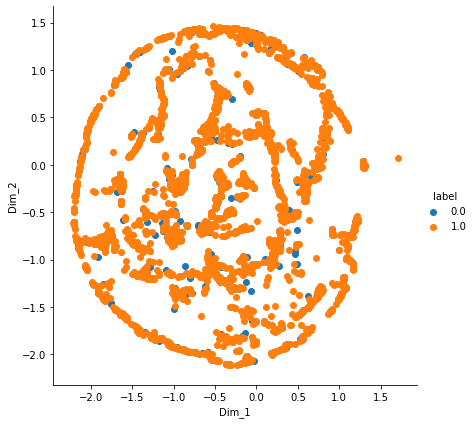

In [42]:
from sklearn.manifold import TSNE
from time import time
labels = final["Score"]
data_2000 = standardized_data[0:5000, 0]
labels_2000 = labels[0:5000]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [43]:
final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [44]:
#split data into train, cross validate and test 
X = final['preprocessed_reviews']
Y = final['Score']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [45]:
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

do we have to create multinomial naive bayes function, can we not use the inbuilt function?

In [46]:
def Multinomial_Naive_Bayes(X_train, X_cv, Y_train, Y_cv):
    selected_lr = 0
    max_roc_auc = -1
    pred_cv = []
    pred_train = []
    possible_lr_list = [0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
    for i in possible_lr_list[-10:]:
        clf = MultinomialNB(alpha=i) # 0.00001
        clf.fit(X_train, Y_train)
        # clf.fit(X_train, y_train)
        # clf.predict(x_test, y_test)
        # clf.predict(X_cv)
        # We know naive bayes uses probability scores to predict on the test dataset or any unseen (validation data)
        probs = clf.predict_proba(X_cv)
        prob = clf.predict_proba(X_train)
        probs = probs[:,1]
        print(probs)
        prob = prob[:, 1]
        # Actual labels: X_cv, Y_cv
        auc_score_cv = roc_auc_score(Y_cv, probs)
        auc_score_train = roc_auc_score(Y_train, prob)
        print(i, " ------->>> Validation AUC-ROC ", auc_score_cv)
        print(i, " ------->>> Train AUC-ROC ", auc_score_train)

        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if max_roc_auc < auc_score_cv:
            max_roc_auc = auc_score_cv
            selected_lr = i
        print("\n The best learning rate selected is: ", selected_lr)
        print("\n The Max AUC-ROC: ", max_roc_auc)
        sns.set_style("darkgrid")
        plt.xscale('log')

    plt.plot(possible_lr_list, pred_cv, 'r-', label="Cross Validation Data")
    plt.plot(possible_lr_list, pred_train, 'g-', label="Training Data")
    plt.legend(loc="upper right")
    plt.title(r'AUC Score V/S $selected_lr$')
    plt.xlabel(r"Learning Rates", fontsize=12)
    plt.ylabel("ROC AUC Score", fontsize=12)
    plt.show()
        
        # Calculate ROC Curve for the model:
        
    fpr, tpr, thresholds = roc_curve(Y_cv, probs)
    plt.plot([0,1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker=".")
    plt.title("Line Plot of ROC Curve on Train Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [48]:
import scikitplot.metrics as skplt
from sklearn import metrics
def testing(X_train, Y_train, X_test, Y_test, optimal_lr):
    clf = MultinomialNB(optimal_lr, fit_prior=True, class_prior=None)
    clf.fit(X_train, Y_train)
    probs = clf.predict_proba(X_test)
    # Storing the probability values for positive outcomes
    probs = probs[:,1]
    print("AUC Score: ", roc_auc_score(Y_test, probs))
    fpr, tpr, thresholds = roc_curve(Y_test, probs)
    plt.plot([0,1], [0,1], linestyle="--")
    
    # Plot the ROC Curve for the model
    plt.plot(fpr, tpr, marker=".")
    plt.title("ROC Curve on Testing Data")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show
    prediction = clf.predict(X_test)
    skplt.plot_confusion_matrix(Y_test, prediction)
    print("F1 Score Macro: ", metrics.f1_score(Y_test, prediction, average='macro'))
    print("F1 Score Micro: ", metrics.f1_score(Y_test, prediction, average="micro"))
    print("hamming loss for data:", metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n", metrics.classification_report(Y_test, prediction))
    return clf

In [49]:
## Bag of Words
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("Bag of Words Size: ",bow_train.get_shape())
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

Bag of Words Size:  (20680, 6967)
CV Data Size:  (10187, 6967)
Test Data Size:  (15204, 6967)


In [50]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
bow_train=preprocessing.normalize(bow_train)
bow_cv=preprocessing.normalize(bow_cv)
bow_test=preprocessing.normalize(bow_test)
print("The shape of out text BOW vectorizer ", bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (20680, 6967)
CV Data Size:  (10187, 6967)
Test Data Size:  (15204, 6967)


[0.87687283 0.98033628 0.96332453 ... 0.96113811 0.68200864 0.99626112]
0.5  ------->>> Validation AUC-ROC  0.9161108326775385
0.5  ------->>> Train AUC-ROC  0.9558024963958338

 The best learning rate selected is:  0.5

 The Max AUC-ROC:  0.9161108326775385
[0.94668128 0.97142067 0.98787911 ... 0.99363928 0.59377735 0.99573384]
0.1  ------->>> Validation AUC-ROC  0.9172682507223316
0.1  ------->>> Train AUC-ROC  0.9727517375548007

 The best learning rate selected is:  0.1

 The Max AUC-ROC:  0.9172682507223316
[0.96816067 0.96956866 0.99295201 ... 0.99770554 0.57819438 0.99562973]
0.05  ------->>> Validation AUC-ROC  0.9127860605782101
0.05  ------->>> Train AUC-ROC  0.9760207562600691

 The best learning rate selected is:  0.1

 The Max AUC-ROC:  0.9172682507223316
[0.99171737 0.96788634 0.99807217 ... 0.99982429 0.56470857 0.99553684]
0.01  ------->>> Validation AUC-ROC  0.8958957774471679
0.01  ------->>> Train AUC-ROC  0.9794663592514709

 The best learning rate selected is:  0.1

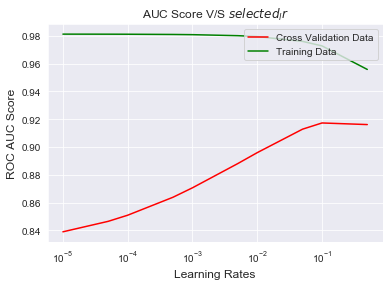

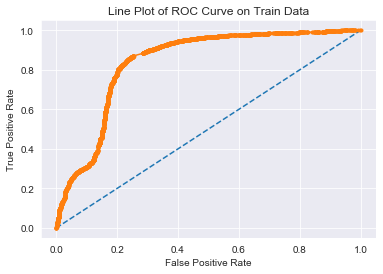

In [51]:
Multinomial_Naive_Bayes(bow_train,bow_cv,Y_tr,Y_cv)

AUC Score:  0.919282622111957
F1 Score Macro:  0.7273836875322102
F1 Score Micro:  0.8852275716916601
hamming loss for data: 0.1147724283083399
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.85      0.37      0.52      2526
           1       0.89      0.99      0.93     12678

    accuracy                           0.89     15204
   macro avg       0.87      0.68      0.73     15204
weighted avg       0.88      0.89      0.87     15204

Model: MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)


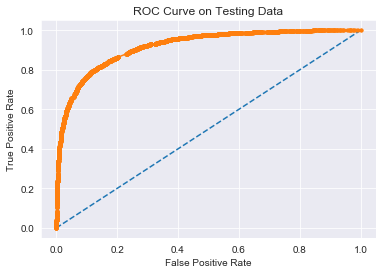

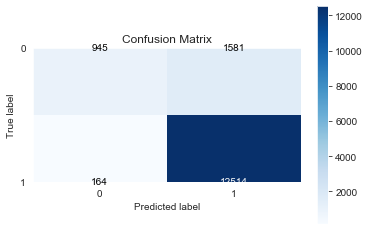

In [52]:
model  = testing(bow_train,Y_tr,bow_test,Y_test,optimal_lr=0.5)
print("Model:", model)

In [53]:
import joblib
joblib.dump(count_vect, open("Count-Vectorizer.pkl", 'wb'))
pickle.dump(model, open("Naive-Bayes.pkl", 'wb'))

In [54]:
cnt_vect = pickle.load(open("Count-Vectorizer.pkl", 'rb'))
naive_bayes = pickle.load(open("Naive-Bayes.pkl", 'rb'))

In [56]:
def predict(string):
    clf = pickle.load(open('Naive-Bayes.pkl', 'rb'))
    count_vect = pickle.load(open("Count-Vectorizer.pkl", 'rb'))
    review_text= decontracted(string)
    review_text = clean_text(string)
    test_vect = count_vect.transform(([review_text]))
    pred = model.predict(test_vect)
    print(pred[0])
    if pred[0]:
        prediction = "Positive"
    else:
        prediction = "Negative"
    return prediction


print(predict("It's too costly for such small quantity"))

  0%|          | 0/46071 [00:00<?, ?it/s]


0
Negative
